# Chapter 9 - Adding external variables to our model

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import itertools as itertls
import statsmodels.api as sm_api

from tqdm import notebook
from typing import Union

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [14]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [28]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    # formatter = mdates.DateFormatter("%Y-%b")
    locator = mdates.YearLocator(base=4)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)


Get all U.S. macro economic data that is collected quarterly from 1959 to 2009

In [32]:
macro_econ_data = sm_api.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Select only `realgdp`  

In [30]:
df_gdp = pd.DataFrame({"year": pd.date_range(start=f"{int(macro_econ_data['year'].iloc[0])}-01-01", 
                  periods=len(macro_econ_data), freq="3M"), 
                  "realgdp": macro_econ_data["realgdp"]})
df_gdp

,year,realgdp
0,1959-01-31,2710.349
1,1959-04-30,2778.801
2,1959-07-31,2775.488
3,1959-10-31,2785.204
4,1960-01-31,2847.699
...,...,...
198,2008-07-31,13324.600
199,2008-10-31,13141.920
200,2009-01-31,12925.410
201,2009-04-30,12901.504


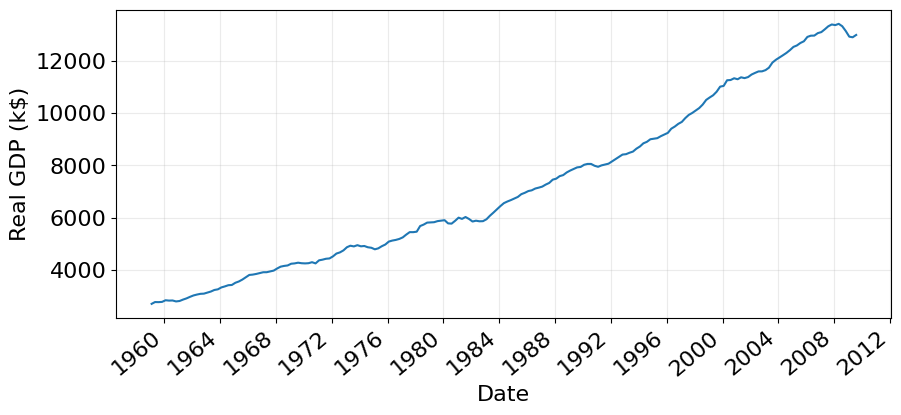

In [31]:
plot_time_series(df_gdp["year"], df_gdp["realgdp"],
                 xlabel="Date", ylabel="Real GDP (k$)")


The GDP is the total market value of all the finished goods and services  
produced within a country. The _real_ GDP is an inflation-adjusted measure  
that removes the impact of inflation on the market value of goods.

Definition of GDP
$$
  \textbf{GDP} = C + G + I + NX
$$
where $C$ is the sum of consumption, $G$ is government spending,  
$I$ is investments, and $NX$ is  net exports.

It is also possible that
- consumptions are impacted by employement rate and interest rates
- net exports are impacted by currency exchange rates

## 9.1 Examining the SARIMAX model